In [1]:
# O-D Demand data prep

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import scipy.stats as stat #, integrate
from scipy.stats import gamma

import networkx as nx
from networkx.readwrite import json_graph

import datetime as dt
import time

import geopandas as gp
from geopandas import sjoin
import shapely as shp
from shapely.geometry import Point, Polygon
import fiona as fio
from fiona.crs import from_epsg

import seaborn as sns
import matplotlib.pyplot as plt
import mplleaflet
from pylab import show

%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
mnd = pd.read_csv('data/master_node.csv')
mnd.drop('Unnamed: 0',inplace=True,axis=1)
mnd.sort_values(by='master_node_id',inplace=True)

In [3]:
ndata = pd.read_csv("data/nyc_subway_stations_with_lines.csv")

geometry = [Point(xy) for xy in zip(ndata['stop_lon'], ndata['stop_lat'])]
crs = {'init': 'epsg:4326', 'no_defs': True}
#    crs = {'init': 'epsg:2263', 'no_defs': True}
ndata_g = gp.GeoDataFrame(ndata, crs=crs, geometry=geometry)       
ndata_g = ndata_g.to_crs(epsg=2263)
ndata_g.drop(['stop_lon','stop_lat','Unnamed: 0'],axis=1,inplace=True)
ndata_g["stop_lon"] = ndata_g.centroid.map(lambda p: p.x)
ndata_g["stop_lat"] = ndata_g.centroid.map(lambda p: p.y)
ndata_g.crs

{'init': 'epsg:2263', 'no_defs': True}

In [4]:
id_splt = pd.DataFrame(mnd.stop_id.str.split(',').tolist(),columns=['stop_id_1','stop_id_2','stop_id_3','stop_id_4'])

In [5]:
mnda =  mnd.merge(id_splt,left_index=True,right_index=True).drop(['stop_id'],axis=1)

In [6]:
stp1 = mnda.merge(
    ndata_g,left_on='stop_id_1',right_on='stop_id')[
    ['master_node_id','stop_name_x','stop_id_1','stop_lon','stop_lat']]

stp2 = mnda.merge(
    ndata_g,left_on='stop_id_2',right_on='stop_id')[
    ['master_node_id','stop_name_x','stop_id_2','stop_lon','stop_lat']]

stp3 = mnda.merge(
    ndata_g,left_on='stop_id_3',right_on='stop_id')[
    ['master_node_id','stop_name_x','stop_id_3','stop_lon','stop_lat']]

stp4 = mnda.merge(
    ndata_g,left_on='stop_id_4',right_on='stop_id')[
    ['master_node_id','stop_name_x','stop_id_4','stop_lon','stop_lat']]

In [7]:
cols = ['master_node_id','stop_name','stop_id','stop_lon','stop_lat']

stp1.columns=cols
stp2.columns=cols
stp3.columns=cols
stp4.columns= cols

mrg = pd.concat([stp1,stp2,stp3,stp4]).reset_index(drop=True)

In [8]:
geometry = [Point(xy) for xy in zip(mrg['stop_lon'], mrg['stop_lat'])]
#crs = {'init': 'epsg:4326', 'no_defs': True}
crs = {'init': 'epsg:2263', 'no_defs': True}
mrg_g = gp.GeoDataFrame(mrg, crs=crs, geometry=geometry)       
#mrg_g = mrg_g.to_crs(epsg=2263)
mrg_g.crs

{'init': 'epsg:2263', 'no_defs': True}

In [9]:
mrg_g.drop(['stop_lon','stop_lat'],axis=1,inplace=True)
mrg_g.sort_values(by='master_node_id',inplace=True)

In [10]:
stations = mrg_g.dissolve(by='master_node_id', as_index=False)

In [11]:
stations['center'] = stations.geometry.centroid
stations = stations.drop(['geometry'],axis=1).set_geometry('center')
stations = stations.rename(columns={'center':'geometry'}).set_geometry('geometry')

crs = {'init': 'epsg:2263', 'no_defs': True}
stations = gp.GeoDataFrame(stations, crs=crs, geometry='geometry')
stations = stations.to_crs(epsg=2263)

print stations.geometry.name, stations.crs

geometry {'init': 'epsg:2263', 'no_defs': True}


In [12]:
stations[stations.duplicated('master_node_id',keep=False) == True]

,master_node_id,stop_name,stop_id,geometry


In [13]:
tracts_sh = gp.read_file('nyct2010_17b/nyct2010.shp')
tracts_sh = tracts_sh.to_crs(epsg=2263)

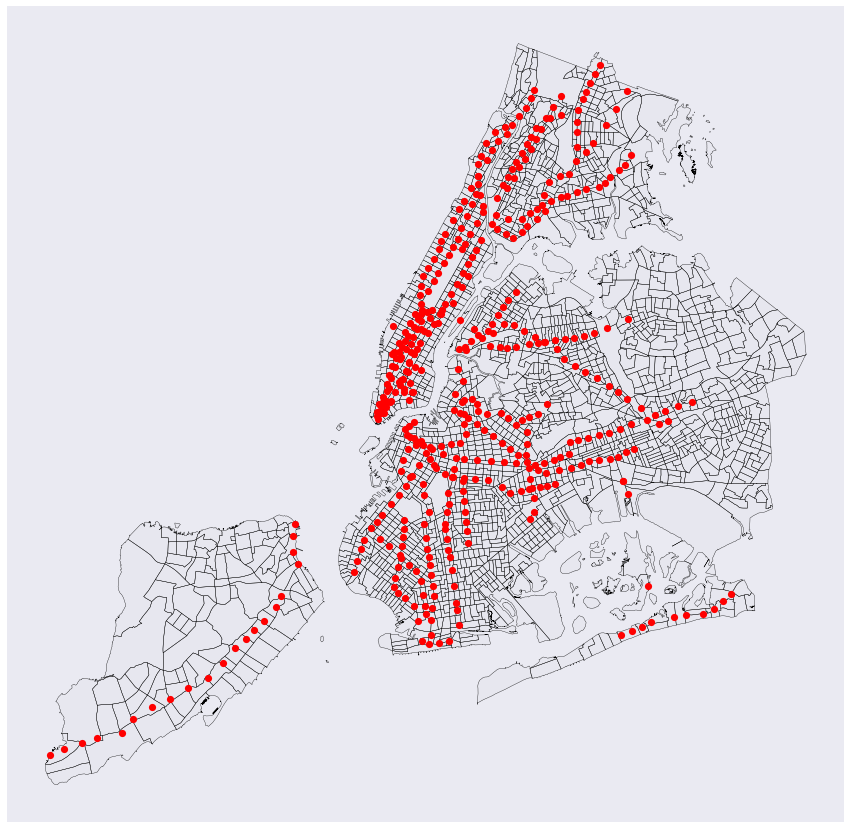

In [14]:
f, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
tracts_sh.geometry.plot(color = 'grey', alpha = .02, linewidth=0.35 ,ax=ax)
stations.geometry.plot(color='red',alpha=1, markersize = 7.2, marker='o',ax=ax)

In [15]:
stations_within_tracts = gp.sjoin(tracts_sh,stations, how='left',op='contains').dropna().sort_values(by='BoroCT2010')
stations_within_tracts.reset_index(drop=True,inplace=True)
stations_within_tracts = stations_within_tracts[['BoroCT2010','master_node_id']]
stations_within_tracts.dropna(inplace=True) 

In [16]:
shortest_distance = []

tct_to_st_dist = tracts_sh.geometry.centroid.apply(lambda s: stations.distance(s))
tct_to_st_dist.columns = np.array(stations.master_node_id)
tct_to_st_dist.index = np.array(tracts_sh.BoroCT2010)

for i in tct_to_st_dist.T.columns:
    shortest_distance.append([i, tct_to_st_dist.T[i].argmin(0), tct_to_st_dist.T[i].min()])

shortest_tct_to_st = pd.DataFrame(shortest_distance,
                                  columns=['BoroCT2010','master_node_id','dddd']).drop(['dddd'],axis=1)

In [17]:
census_stations =shortest_tct_to_st.merge(
    stations_within_tracts,on='BoroCT2010',how='outer',indicator=True).sort_values(by='BoroCT2010')

In [18]:
stations_within_tracts = census_stations[census_stations['_merge'] == 'both']
stations_within_tracts.columns = ['BoroCT2010','gggg','master_node_id','relationship']
stations_within_tracts.drop(['gggg'],axis=1,inplace=True)
stations_within_tracts['relationship'] = 'within'

shortest_tct_to_st = census_stations[census_stations['_merge'] == 'left_only']
shortest_tct_to_st.columns = ['BoroCT2010','master_node_id','gggg','relationship']
shortest_tct_to_st.drop(['gggg'],axis=1,inplace=True)
shortest_tct_to_st['relationship'] = 'closest'

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarnin

In [19]:
station_choice = pd.concat([shortest_tct_to_st,stations_within_tracts]).sort_values(by='BoroCT2010') #.groupby(['_merge','BoroCT2010']).count()

In [20]:
station_choice['tally'] = 1

In [21]:
station_choice.head(9)

,BoroCT2010,master_node_id,relationship,tally
912,1000100,Bowling Green_0,closest,1
2031,1000201,East Broadway_0,closest,1
2030,1000202,East Broadway_0,closest,1
2190,1000500,Whitehall St_0,closest,1
1345,1000600,East Broadway_0,within,1
2195,1000700,Wall St_0,within,1
2194,1000700,Wall St_1,within,1
2193,1000700,Broad St_0,within,1
1425,1000800,East Broadway_0,closest,1


In [23]:
station_choice_tr = 1/station_choice.groupby('BoroCT2010').agg({'tally':'sum'})
station_choice_tr.reset_index(inplace=True)
station_choice_tr = station_choice_tr.merge(station_choice,on='BoroCT2010').drop(['tally_y'],axis=1).rename(columns={'tally_x':'tally'})

In [25]:
station_choice_tr.head(5)

,BoroCT2010,tally,master_node_id,relationship
0,1000100,1.0,Bowling Green_0,closest
1,1000201,1.0,East Broadway_0,closest
2,1000202,1.0,East Broadway_0,closest
3,1000500,1.0,Whitehall St_0,closest
4,1000600,1.0,East Broadway_0,within


In [26]:
tract_station_matrix = station_choice_tr.pivot(index='BoroCT2010', columns='master_node_id',values='tally').fillna(0)

In [27]:
tract_station_matrix.T.sum().sum()

2166.0

In [28]:
tract_station_matrix

master_node_id,1 Av_0,103 St - Corona Plaza_0,103 St_0,103 St_1,103 St_2,104 St_0,104 St_1,110 St_0,111 St_0,111 St_1,...,Whitlock Av_0,Wilson Av_0,Winthrop St_0,Woodhaven Blvd_0,Woodhaven Blvd_1,Woodlawn_0,Woodside - 61 St_0,World Trade Center_0,York St_0,Zerega Av_0
BoroCT2010,,,,,,,,,,,,,,,,,,,,,
1000100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1000900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [29]:
od = pd.read_csv('nyc_journey_type.csv')
od.dropna(inplace='True')
od_trim = od[['Borough','Borough.1','Census Tract','Census Tract.1','Subway or Elevated']]
od_trim['Borough'] = od_trim['Borough'].str[1:-1]
od_trim['Borough.1'] = od_trim['Borough.1'].str[1:-1]
od_trim.rename(columns={'Borough':'Boro_home','Borough.1':'Boro_work',
                        'Census Tract':'Tract_short_home','Census Tract.1':'Tract_short_work',
                        'Subway or Elevated':'Passengers'},inplace=True)
od_trim['Pair_id'] = od_trim.index

od_trim.head(5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/anaconda/lib/python2.7/site-packages/ip

,Boro_home,Boro_work,Tract_short_home,Tract_short_work,Passengers,Pair_id
0,Bronx,Bronx,200.0,200.0,0.0,0
1,Bronx,Bronx,200.0,400.0,0.0,1
2,Bronx,Bronx,200.0,1600.0,0.0,2
3,Bronx,Bronx,200.0,3300.0,0.0,3
4,Bronx,Bronx,200.0,4200.0,0.0,4


In [30]:
temp_h = od_trim.merge(tracts_sh,
              left_on=['Boro_home','Tract_short_home'],
              right_on=['BoroName',tracts_sh.BoroCT2010.astype(str).str[1:].astype(float)])

temp_h = temp_h[['BoroCT2010','Passengers','Pair_id']].rename(columns={'BoroCT2010':'Tract_home'})
#temp_h = temp_h.merge(station_choice_tr[['BoroCT2010']],left_on='Tract_home',right_on='BoroCT2010',how='right',indicator=True)

#temp_h.Tract_home = temp_h.Tract_home.fillna(temp_h.BoroCT2010)
#temp_h.Passengers = temp_h.Passengers.fillna(0)
#temp_h.drop(['BoroCT2010','_merge'],axis=1,inplace=True)
temp_h.head(5)

,Tract_home,Passengers,Pair_id
0,2000200,0.0,0
1,2000200,0.0,1
2,2000200,0.0,2
3,2000200,0.0,3
4,2000200,0.0,4


In [31]:
temp_w = od_trim.merge(tracts_sh,
              left_on=['Boro_work','Tract_short_work'],
              right_on=['BoroName',tracts_sh.BoroCT2010.astype(str).str[1:].astype(float)])

temp_w = temp_w[['BoroCT2010','Pair_id']].rename(columns={'BoroCT2010':'Tract_work'})

#temp_w = temp_w.merge(station_choice_tr[['BoroCT2010']],left_on='Tract_work',right_on='BoroCT2010',how='right',indicator=True)

#temp_w.Tract_work = temp_w.Tract_work.fillna(temp_w.BoroCT2010)
#temp_w.drop(['BoroCT2010','_merge'],axis=1,inplace=True)
temp_w.head(5)

,Tract_work,Pair_id
0,2000200,0
1,2000200,275
2,2000200,531
3,2000200,2421
4,2000200,2450


In [32]:
od_dem = temp_h.merge(temp_w,on='Pair_id')
od_dem = od_dem[['Tract_home','Tract_work','Passengers']]
od_dem.head(5)

,Tract_home,Tract_work,Passengers
0,2000200,2000200,0.0
1,2000200,2000400,0.0
2,2000200,2001600,0.0
3,2000200,2003300,0.0
4,2000200,2004200,0.0


In [33]:
od_demand = od_dem.pivot(index='Tract_home', columns='Tract_work',values='Passengers').fillna(0)

In [34]:
tract_station_matrix_work = pd.DataFrame(od_demand.index).merge(tract_station_matrix.reset_index(),left_on='Tract_home',right_on='BoroCT2010')
tract_station_matrix_work.index=tract_station_matrix_work.BoroCT2010
tract_station_matrix_work.drop(['Tract_home','BoroCT2010'],inplace=True,axis=1)

tract_station_matrix_home = pd.DataFrame(od_demand.T.index).merge(tract_station_matrix.reset_index(),left_on='Tract_work',right_on='BoroCT2010')
tract_station_matrix_home.index=tract_station_matrix_home.BoroCT2010
tract_station_matrix_home.drop(['Tract_work','BoroCT2010'],inplace=True,axis=1)

In [35]:
next_guy = pd.DataFrame(np.dot(od_demand,tract_station_matrix_home),
                        columns=tract_station_matrix_home.columns,
                        index=od_demand.index)

In [36]:
another_guy = pd.DataFrame(np.dot(od_demand.T,tract_station_matrix_work),
                           columns=tract_station_matrix_work.columns,
                           index=od_demand.T.index)


In [37]:
the_matrix = pd.DataFrame(np.dot(next_guy.T,tract_station_matrix_work),
                          columns=tract_station_matrix_work.columns,
                          index=next_guy.T.index)
the_matrix.index.name = 'work_station'
the_matrix.columns.name = 'home_station'

In [38]:
another_matrix = pd.DataFrame(np.dot(another_guy.T,tract_station_matrix_home),
                              columns=tract_station_matrix_home.columns,
                              index=next_guy.T.index)

In [39]:
Station_Flow = pd.DataFrame(the_matrix.sum()).merge(
    pd.DataFrame(the_matrix.T.sum()),
    right_index=True,
    left_index=True).rename(columns={'0_x':'home_station','0_y':'work_station'})

In [40]:
the_matrix.astype(int).astype(float)

home_station,1 Av_0,103 St - Corona Plaza_0,103 St_0,103 St_1,103 St_2,104 St_0,104 St_1,110 St_0,111 St_0,111 St_1,...,Whitlock Av_0,Wilson Av_0,Winthrop St_0,Woodhaven Blvd_0,Woodhaven Blvd_1,Woodlawn_0,Woodside - 61 St_0,World Trade Center_0,York St_0,Zerega Av_0
work_station,,,,,,,,,,,,,,,,,,,,,
1 Av_0,70.0,70.0,15.0,40.0,30.0,0.0,10.0,0.0,25.0,50.0,...,25.0,15.0,10.0,20.0,30.0,0.0,55.0,0.0,0.0,0.0
103 St - Corona Plaza_0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
103 St_0,0.0,15.0,95.0,40.0,0.0,0.0,0.0,0.0,0.0,70.0,...,0.0,0.0,10.0,10.0,0.0,0.0,35.0,0.0,0.0,0.0
103 St_1,75.0,35.0,0.0,75.0,0.0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,15.0,50.0,20.0,45.0,7.0,0.0,25.0,45.0
103 St_2,0.0,4.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
104 St_0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104 St_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110 St_0,0.0,60.0,10.0,0.0,0.0,0.0,0.0,85.0,15.0,0.0,...,0.0,0.0,10.0,15.0,10.0,0.0,30.0,0.0,0.0,0.0
111 St_0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
print ('total subway riders:', the_matrix.sum().sum())

('total subway riders:', 1428480.0)


In [42]:
Station_Flow.astype(int).astype(float).to_csv('data/station_flow.csv')

In [43]:
od_demand.T.to_csv('data/od_table_by_tract.csv')

In [44]:
tract_station_matrix.to_csv('data/census_station_pairs.csv')

In [45]:
the_matrix.astype(int).astype(float).to_csv('data/station_to_station_od_matrix.csv')